In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pickle
from tqdm import tqdm
from mpl_toolkits import mplot3d

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
import cfg

save = 'figures/ip3_ca_experiments/'

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def ip3_ca_ode_equations(t, x, ip3_input_type=None, Gstar=None):
    '''
    ODE equations detailing the calcium transient response to a
    given IP3 level
    Pass Gstar in if we are doing the full ODE system
    '''
    c = x[0] #Cytosolic Ca2+ concentration
    c_tot = x[1] #Total free Ca2+ concentration in cell
    h = x[2] #Deactivation parameter for IP3R
    p = 0 #IP3 concentration
    
    
    #We can choose to either use ODE for IP3 or manually input it
    #ODE
    if(ip3_input_type == None):
        p = x[3] #IP3 concentration
    
    #Explicit input
    else:
        p = get_input_value(ip3_input_type, t)
    
    #Compute ER Ca2+ concentration based on total Ca2+ and Cyt Ca2+
    c_er = (c_tot - c) * cfg.gamma
    
    #First compute some derivative values that will be needed
    #for h and IP3R dynamics
    m_inf = p / (p + cfg.d1)
    n_inf = c / (c + cfg.d5)
    Q2 = cfg.d2 * (p + cfg.d1) / (p + cfg.d3)
    h_inf = Q2 / (Q2 + c)
    tau_h = 1 / (cfg.a2 * (Q2 + c))
    
    #Compute the fluxes through each channel
    J_ip3r = cfg.v_ip3r * (m_inf**3) * (n_inf**3) * (h**3) * (c_er - c)
    J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)
    J_pmca = cfg.v_pmca * (c**2) / (c**2 + cfg.k_pmca**2)
    J_soc = cfg.v_soc * (cfg.k_soc**4) / (cfg.k_soc**4 + c_er**4)
#     J_soc = cfg.v_soc * (cfg.k_soc**2) / (cfg.k_soc**2 + c_er**2)
    
    #leak fluxes
    J_er_leak = cfg.v_er_leak * (c_er - c) #ER <-> Cyt leak
    J_ecs_add = cfg.v_in - cfg.k_out * c #Cyt <-> extracellular leak
    
#     x_dot = np.zeros(len(x))
    x_dot = []
    
#     x_dot[0] = J_ip3r + J_er_leak - J_serca + cfg.delta*(J_ecs_add - J_pmca + J_soc)
#     x_dot[1] = cfg.delta*(J_ecs_add - J_pmca + J_soc)
#     x_dot[2] = (h_inf - h) / tau_h
#     x_dot[3] = ip3_ode_equation(t, x, Gstar)

    x_dot.append(J_ip3r + J_er_leak - J_serca + cfg.delta*(J_ecs_add - J_pmca + J_soc))
    x_dot.append(cfg.delta*(J_ecs_add - J_pmca + J_soc))
    x_dot.append((h_inf - h) / tau_h)

    return x_dot
    
    



def ip3_ode_equation(t, x, Gstar=None):
    '''
    ODE equations for IP3 production and degradation
    This function will be called by ip3_ca_ode_equations if
    manual_ip3 is set to False and we are simulating dynamics
    '''
    c = x[0] #Cytosolic Ca2+ concentration
    c_tot = x[1] #Total free Ca2+ concentration in cell
    h = x[2] #Deactivation parameter for IP3R
    p = x[3] #IP3 concentration 
    
    if(Gstar == None):
        #use a square wave for Gstar for now
        Gstar = pulse_input(t)
        #Gstar = 0
        
    ip3_production = cfg.v_beta*Gstar + cfg.v_delta*((cfg.k_delta)/(1 + p))*((c**2)/(c**2 + cfg.k_plcdelta**2))
    ip3_degradation = cfg.v_3k*((c**4)/(c**4 + cfg.k_d**4))*(p/(p+cfg.k_3)) + cfg.r_5p*p
#     ip3_degradation = cfg.v_3k*((c**2)/(c**2 + k_d**2))*(p/(p+cfg.k_3)) + cfg.r_5p*p
    
    return ip3_production - ip3_degradation

In [2]:
cfg.input_start = 0
cfg.input_max = 0.35
cfg.input_duration = 500

hs = np.arange(0.40, 0.65, 0.001)
cs = np.arange(0, 2.8, 0.01)
c_tots = np.arange(18, 37, 0.1)

# hs = np.arange(0.40, 0.65, 0.003)
# cs = np.arange(0, 2.8, 0.03)
# c_tots = np.arange(18, 37, 0.2)

grid = np.meshgrid(cs, c_tots, hs)

In [3]:
x_dot = ip3_ca_ode_equations(10, grid, 'pulse')

In [6]:
x_dot_tot = np.abs(x_dot[0]) + np.abs(x_dot[1]) + np.abs(x_dot[2])

In [7]:
#this should give the fixed point
idx = np.isclose(x_dot_tot, np.zeros(x_dot_tot.shape), atol=1e-3)
idx = idx.reshape(-1)
print(grid[0].reshape(-1)[idx])
print(grid[1].reshape(-1)[idx])
print(grid[2].reshape(-1)[idx])

[]
[]
[]


In [60]:
idx = np.isclose(x_dot_tot, np.zeros(x_dot_tot.shape), atol=2e-2)

In [4]:
idx = np.isclose(x_dot[0], np.zeros(x_dot[0].shape), atol=3e-4).reshape(-1)
c_zero_c = grid[0].reshape(-1)[idx]
c_tot_zero_c = grid[1].reshape(-1)[idx]
h_zero_c = grid[2].reshape(-1)[idx]
np.sum(idx)

4538

In [ ]:
#h and c_t derivatives are functions only of two variables, much easier to compute manually


In [24]:
np.unique(c_tot_zero_ct)

array([19.9, 24.8, 25.9, 26.5, 27.1, 27.8, 29.4, 30.3, 31.4, 32.6, 34. ,
       34.1, 35.7, 35.8, 35.9])

In [9]:
%matplotlib qt

In [6]:
cfg.input_max = 0.354
x_dot = ip3_ca_ode_equations(10, grid, 'pulse')
idx = np.isclose(x_dot[0], np.zeros(x_dot[0].shape), atol=3e-4).reshape(-1)
c_zero_c = grid[0].reshape(-1)[idx]
c_tot_zero_c = grid[1].reshape(-1)[idx]
h_zero_c = grid[2].reshape(-1)[idx]
np.sum(idx)

4363

In [13]:
cfg.input_max = 0.354
sol = run_ip3_controlled_experiment('pulse', t_f=500, max_step=0.5)

#Manualy compute zeros for c_t and h dot
c1 = np.linspace(0.04, 0.53, 2000)
#c_total as a function of c for which c_t dot is zero (null surface)
J_pmca = cfg.v_pmca * (c1**2) / (c1**2 + cfg.k_pmca**2)
J_ecs_add = cfg.v_in - cfg.k_out * c1
c_tot_dot_zero = ((cfg.k_soc**4 / (J_pmca - J_ecs_add) - cfg.k_soc**4) / cfg.gamma**4)**(1/4) + c1

c2 = np.linspace(0, 2.5, 1000)
#h as a function of c for which h dot is zero (null surface)
p = cfg.input_max
Q2 = cfg.d2 * (p + cfg.d1) / (p + cfg.d3)
h_dot_zero = Q2 / (Q2 + c2)


idx = (h_dot_zero < cfg.h.max()) & (h_dot_zero > cfg.h.min())
c2 = c2[idx]
h_dot_zero = h_dot_zero[idx]

h0_cs = []
h0_hs = []
h0_cts = []
ct_max = cfg.c_tot.max()
ct_min = cfg.c_tot.min()
ct_select = [ct_min, ct_max]
for i in range(len(c2)):    
    for j in range(2):
        h0_cs.append(c2[i])
        h0_hs.append(h_dot_zero[i])
        h0_cts.append(ct_select[(i + j) % 2])
        
ct0_cs = []
ct0_hs = []
ct0_cts = []
h_max = cfg.h.max()
h_min = cfg.h.min()
h_select = [h_min, h_max]
hs = np.linspace(h_min, h_max, 100)
counter = 0
# for h in hs:
# for j in range(2):

idx = (c_tot_dot_zero < cfg.c_tot.max()) & (c_tot_dot_zero > cfg.c_tot.min())
c1 = c1[idx]
c_tot_dot_zero = c_tot_dot_zero[idx]

for i in range(len(c1)):
    for j in range(2):
#         if np.isnan(c_tot_dot_zero[i]):
#             continue
        ct0_cs.append(c1[i])
        ct0_hs.append(h_select[(j + i) % 2])
#         ct0_hs.append(h)
        ct0_cts.append(c_tot_dot_zero[i])
        


plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.plot_trisurf(c_zero_c, c_tot_zero_c, h_zero_c)
ax.plot(ct0_cs, ct0_cts, ct0_hs, alpha=0.5, c='C2')
ax.plot_trisurf(h0_cs, h0_cts, h0_hs)

ax.plot(cfg.c, cfg.c_tot, cfg.h, c='C0')
# sol = 

ax.set_ylim([cfg.c_tot.min(), cfg.c_tot.max()])

C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less
C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


(18.420760976920945, 27.874050268547503)

In [19]:
cfg.input_max = 0.2
x_dot = ip3_ca_ode_equations(10, grid, 'pulse')
idx = np.isclose(x_dot[0], np.zeros(x_dot[0].shape), atol=3e-4).reshape(-1)
c_zero_c2 = grid[0].reshape(-1)[idx]
c_tot_zero_c2 = grid[1].reshape(-1)[idx]
h_zero_c2 = grid[2].reshape(-1)[idx]
np.sum(idx)

4608

In [24]:
cfg.c_tot

array([27.8729472 , 27.87370301, 27.87452884, ..., 23.52869263,
       23.5469392 , 23.56223675])

In [25]:
idx = (c_tot_zero_c2 < cfg.c_tot.max()) & (c_tot_zero_c2 > cfg.c_tot.min())

In [26]:
c_zero_c2 = c_zero_c2[idx]
c_tot_zero_c2 = c_tot_zero_c2[idx]
h_zero_c2 = h_zero_c2[idx]


In [27]:
cfg.input_max = 0.2
sol = run_ip3_controlled_experiment('pulse', t_f=500, max_step=0.5)

#Manualy compute zeros for c_t and h dot
c1 = np.linspace(0.04, 0.53, 2000)
#c_total as a function of c for which c_t dot is zero (null surface)
J_pmca = cfg.v_pmca * (c1**2) / (c1**2 + cfg.k_pmca**2)
J_ecs_add = cfg.v_in - cfg.k_out * c1
c_tot_dot_zero = ((cfg.k_soc**4 / (J_pmca - J_ecs_add) - cfg.k_soc**4) / cfg.gamma**4)**(1/4) + c1

c2 = np.linspace(0, 2.5, 1000)
#h as a function of c for which h dot is zero (null surface)
p = cfg.input_max
Q2 = cfg.d2 * (p + cfg.d1) / (p + cfg.d3)
h_dot_zero = Q2 / (Q2 + c2)


idx = (h_dot_zero < cfg.h.max()) & (h_dot_zero > cfg.h.min())
c2 = c2[idx]
h_dot_zero = h_dot_zero[idx]

h0_cs = []
h0_hs = []
h0_cts = []
ct_max = cfg.c_tot.max()
ct_min = cfg.c_tot.min()
ct_select = [ct_min, ct_max]
for i in range(len(c2)):    
    for j in range(2):
        h0_cs.append(c2[i])
        h0_hs.append(h_dot_zero[i])
        h0_cts.append(ct_select[(i + j) % 2])
        
ct0_cs = []
ct0_hs = []
ct0_cts = []
h_max = cfg.h.max()
h_min = cfg.h.min()
h_select = [h_min, h_max]
hs = np.linspace(h_min, h_max, 100)
counter = 0
# for h in hs:y

# for j in range(2):

idx = (c_tot_dot_zero < cfg.c_tot.max()) & (c_tot_dot_zero > cfg.c_tot.min())
c1 = c1[idx]
c_tot_dot_zero = c_tot_dot_zero[idx]

for i in range(len(c1)):
    for j in range(2):
#         if np.isnan(c_tot_dot_zero[i]):
#             continue
        ct0_cs.append(c1[i])
        ct0_hs.append(h_select[(j + i) % 2])
#         ct0_hs.append(h)
        ct0_cts.append(c_tot_dot_zero[i])
        


plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.plot_trisurf(c_zero_c2, c_tot_zero_c2, h_zero_c2)
ax.plot(ct0_cs, ct0_cts, ct0_hs, alpha=0.5, c='C2')
ax.plot_trisurf(h0_cs, h0_cts, h0_hs)

x_0 = [0.0951442, 34.841184, 0.673079, 0.056767761]


ax.plot(cfg.c, cfg.c_tot, cfg.h)
ax.set_ylim([cfg.c_tot.min(), cfg.c_tot.max()])

C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less
C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater


(23.467143028228787, 27.87452884324276)

In [37]:
c_tot

array([-3034465.53446554, -3034465.53196304, -3034465.52946054,
       -3034465.52695804, -3034465.52445554, -3034465.52195304,
       -3034465.51945053, -3034465.51694803, -3034465.51444553,
       -3034465.51194303, -3034465.50944053, -3034465.50693804,
       -3034465.50443554, -3034465.50193305, -3034465.49943057,
       -3034465.49692816, -3034465.49442476, -3034465.49192288,
       -3034465.48942043, -3034465.48691794, -3034465.48441545,
       -3034465.48191296, -3034465.47941046, -3034465.47690796,
       -3034465.47440546, -3034465.47190296, -3034465.46940046,
       -3034465.46689796, -3034465.46439545, -3034465.46189295,
       -3034465.45939045, -3034465.45688795, -3034465.45438545,
       -3034465.45188294, -3034465.44938044, -3034465.44687794,
       -3034465.44437544, -3034465.44187294, -3034465.43937043,
       -3034465.43686793, -3034465.43436543, -3034465.43186293,
       -3034465.42936042, -3034465.42685792, -3034465.42435542,
       -3034465.42185292, -3034465.41935

In [16]:
x_0 = [0.0951442, 34.841184, 0.673079, 0.056767761]
cfg.input_duration = 2000
sol = run_ip3_controlled_experiment('pulse', t_f=1000, max_step=0.5)

plt.figure(figsize=(10,5))
plt.plot(cfg.t, cfg.c)

# cfg.x_0[1] = x_0[1] * 0.8
# sol = run_ip3_controlled_experiment('pulse', t_f=500, max_step=0.5)
# plt.plot(cfg.t, cfg.c)

In [17]:
cfg.input_max

0.354

# Messing with initial conditions

In [20]:
cfg.input_max = 0.35
cfg.input_duration = 500
cfg.input_start = 0
sol = run_ip3_controlled_experiment('pulse', max_step=1, t_f=500)


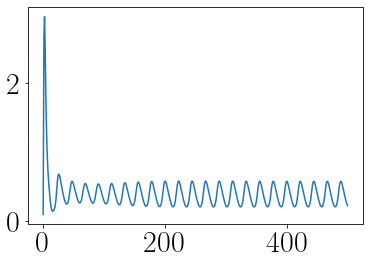

In [21]:
plt.plot(cfg.t, cfg.c)

In [ ]:
def delay():
    peaks = scipy.signal.find_peaks(cfg.c)[0]
    low_peak = cfg.c[peaks].argmin()
    

In [22]:
peaks = scipy.signal.find_peaks(cfg.c)[0]

In [23]:
cfg.c[peaks].argmin()

4

In [25]:
cfg.c[peaks][4:].max()

0.5774231851303734

In [ ]:
cfg.c[peaks]

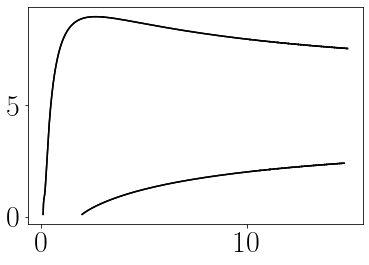

In [3]:
plot_bifurcation('2_param_glut_v3k.dat')